In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from scikeras.wrappers import KerasClassifier
from classification_utils import *
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.constraints import MaxNorm

In [2]:
data = pd.read_csv("dataset/cleaned_user_profiles.csv", index_col=0)

In [3]:
data.head()

,name,lang,bot,created_at,statuses_count,avg_length,avg_special_chars,urls_ratio,mentions_ratio,hashtags_ratio,reply_count_mean,reply_count_std,favorite_count_mean,favorite_count_std,favorite_count_entropy,retweet_count_mean,retweet_count_std
2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76,62.340909,14.015152,0.000000,0.272727,0.098485,0.0,0.0,0.037879,0.190903,0.232481,0.037879,0.190903
2358850842,Lourie Botton,en,0,2019-02-26 03:02:32,54,69.082645,15.041322,0.000000,0.338843,0.024793,0.0,0.0,0.049587,0.217090,0.284639,0.024793,0.155495
137959629,Dadan Syarifudin,en,1,2015-04-30 07:09:56,53,65.340909,14.694444,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
466124818,Carletto Focia,it,1,2017-01-18 02:49:18,50,86.944871,18.689463,0.022331,0.006281,0.072575,0.0,0.0,0.165387,0.530838,0.669155,0.826239,13.034008
2571493866,MBK Ebook,en,0,2019-06-18 19:30:21,7085,72.311246,14.582073,0.000825,0.506461,0.118229,0.0,0.0,0.056365,0.243387,0.317182,0.016772,0.142619


In [4]:
data.describe()

,bot,statuses_count,avg_length,avg_special_chars,urls_ratio,mentions_ratio,hashtags_ratio,reply_count_mean,reply_count_std,favorite_count_mean,favorite_count_std,favorite_count_entropy,retweet_count_mean,retweet_count_std
count,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000
mean,0.531456,5148.794751,67.100135,15.045892,0.031045,0.329076,0.088484,0.001967,0.023941,0.084281,0.365536,0.385427,1.357545,14.574041
std,0.499031,18496.606420,12.755296,2.454106,0.053379,0.315589,0.070828,0.007796,0.068508,0.109621,0.408358,0.390777,2.827068,23.390000
min,0.000000,0.000000,32.500000,9.644166,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,53.000000,59.686796,13.553296,0.000000,0.010260,0.045455,0.000000,0.000000,0.017751,0.136692,0.119116,0.010526,0.104251
50%,1.000000,57.000000,65.340909,14.694444,0.005109,0.300971,0.070423,0.000000,0.000000,0.045752,0.230747,0.268594,0.043478,0.238606
75%,1.000000,2041.000000,74.254999,16.772205,0.037445,0.450781,0.113295,0.000000,0.000000,0.088862,0.451218,0.491767,0.949402,24.144412
max,1.000000,399555.000000,104.449541,22.000000,0.287760,1.210354,0.337268,0.044444,0.333767,0.529903,2.183383,1.723913,12.902439,198.461303


In [5]:
data.isnull().values.any()

False

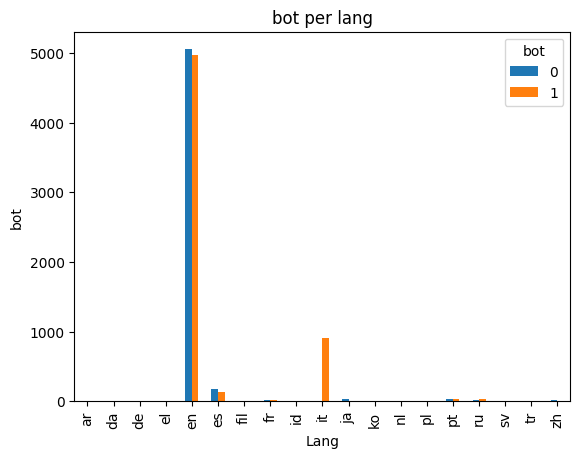

In [6]:
plot_lang_hist(data)

In [7]:
data = data.join(pd.get_dummies(data["lang"]))

In [8]:
train_set, test_set, train_label, test_label = prepare_data(data)

Classification features : ['created_at', 'statuses_count', 'avg_length', 'avg_special_chars', 'urls_ratio', 'mentions_ratio', 'hashtags_ratio', 'reply_count_mean', 'reply_count_std', 'favorite_count_mean', 'favorite_count_std', 'favorite_count_entropy', 'retweet_count_mean', 'retweet_count_std', 'ar', 'da', 'de', 'el', 'en', 'es', 'fil', 'fr', 'id', 'it', 'ja', 'ko', 'nl', 'pl', 'pt', 'ru', 'sv', 'tr', 'zh']


In [9]:
scaler = StandardScaler()
scaler.fit(train_set)
scaled_train_set = scaler.transform(train_set)
scaled_test_set = scaler.transform(test_set)

In [10]:
# Function to create model, required for KerasClassifier
def create_model1():
    # create model
    model = Sequential()
    model.add(Dense(10, input_shape=(train_set.shape[1],), activation='relu'))
    model.add(Dense(5, input_shape=(train_set.shape[1],), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [12]:
seed = 7
tf.random.set_seed(seed)

model = KerasClassifier(model=create_model1, loss="binary_crossentropy", optimizer="SGD",
                        epochs=100, batch_size=10, verbose=5)

learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]

param_grid = dict(
    optimizer__learning_rate=learn_rate,
    optimizer__momentum=momentum
)

grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    n_jobs=-1,
    cv=3,
    verbose = 4
)

grid_result = grid.fit(train_set, train_label)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100

In [ ]:
def create_model2():
    # create model
    model = Sequential()
    model.add(Dense(10, input_shape=(train_set.shape[1],), activation='relu'))
    model.add(Dense(10, input_shape=(train_set.shape[1],), activation='relu'))
    model.add(Dense(5, input_shape=(train_set.shape[1],), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [ ]:
seed = 7
tf.random.set_seed(seed)

model = KerasClassifier(model=create_model2, loss="binary_crossentropy", optimizer="SGD",
                        epochs=100, batch_size=10, verbose=5)

learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]

param_grid = dict(
    optimizer__learning_rate=learn_rate,
    optimizer__momentum=momentum
)

grid1 = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    n_jobs=-1,
    cv=3,
    verbose = 4
)

grid_result = grid.fit(train_set, train_label)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
def create_model3():
    # create model
    model = Sequential()
    model.add(Dense(25, input_shape=(train_set.shape[1],), activation='relu'))
    model.add(Dense(10, input_shape=(train_set.shape[1],), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [ ]:
seed = 7
tf.random.set_seed(seed)

model = KerasClassifier(model=create_model3, loss="binary_crossentropy", optimizer="SGD",
                        epochs=100, batch_size=10, verbose=5)

learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]

param_grid = dict(
    optimizer__learning_rate=learn_rate,
    optimizer__momentum=momentum
)

grid2 = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    n_jobs=-1,
    cv=3,
    verbose = 4
)

grid_result = grid.fit(train_set, train_label)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
def create_model4():
    # create model
    model = Sequential()
    model.add(Dense(25, input_shape=(train_set.shape[1],), activation='relu'))
    model.add(Dense(25, input_shape=(train_set.shape[1],), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [ ]:
seed = 7
tf.random.set_seed(seed)

model = KerasClassifier(model=create_model4, loss="binary_crossentropy", optimizer="SGD",
                        epochs=100, batch_size=10, verbose=5)

learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]

param_grid = dict(
    optimizer__learning_rate=learn_rate,
    optimizer__momentum=momentum
)

grid3 = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    n_jobs=-1,
    cv=3,
    verbose = 4
)

grid_result = grid.fit(train_set, train_label)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
def create_model5():
    # create model
    model = Sequential()
    model.add(Dense(20, input_shape=(train_set.shape[1],), activation='relu'))
    model.add(Dense(10, input_shape=(train_set.shape[1],), activation='relu'))
    model.add(Dense(10, input_shape=(train_set.shape[1],), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [ ]:
seed = 7
tf.random.set_seed(seed)

model = KerasClassifier(model=create_model5, loss="binary_crossentropy", optimizer="SGD",
                        epochs=100, batch_size=10, verbose=5)

learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]

param_grid = dict(
    optimizer__learning_rate=learn_rate,
    optimizer__momentum=momentum
)

grid4 = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    n_jobs=-1,
    cv=3,
    verbose = 4
)

grid_result = grid.fit(train_set, train_label)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
nn = grid.best_estimator_ #aggiungere numero dopo 'grid' per il miglior modello

In [ ]:
train_pred = nn.predict(scaled_train_set)
test_pred = nn.predict(scaled_test_set)

In [ ]:
print_metrics(train_label, train_pred, test_label, test_pred)

In [ ]:
#compute the performance of the model
report_scores(test_label, test_pred)

In [ ]:
# cross validation
scores = cross_validate(nn, scaled_train_set, train_label, cv = 3, return_train_score= True)
print('Fit time ', statistics.mean(scores['fit_time']))
print('Score time ', statistics.mean(scores['score_time']))
print('Test score ', statistics.mean(scores['test_score']))
print('Train score ', statistics.mean(scores['train_score']))

In [ ]:
predictions = nn.predict(scaled_test_set)

cm = confusion_matrix(test_label, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()

In [ ]:
pca = PCA(n_components=2)
test_set_reduced = pca.fit_transform(scaled_test_set)

In [ ]:
plt.scatter(test_set_reduced[:, 0], test_set_reduced[:, 1], c=test_label);

In [ ]:
plt.scatter(test_set_reduced[:, 0], test_set_reduced[:, 1], c=test_pred);

In [ ]:
with open("models_checkpoints/keras_nn_lang.bin", "wb") as f:
    pickle.dump(nn, f)

### Without lang

In [ ]:
data = pd.read_csv("dataset/cleaned_user_profiles.csv", index_col=0)

In [ ]:
data.drop(columns=['lang'])

In [ ]:
train_set, test_set, train_label, test_label = prepare_data(data)

In [ ]:
scaler = StandardScaler()
scaler.fit(train_set)
scaled_train_set = scaler.transform(train_set)
scaled_test_set = scaler.transform(test_set)

In [ ]:
scaler = StandardScaler()
scaler.fit(train_set)
scaled_train_set = scaler.transform(train_set)
scaled_test_set = scaler.transform(test_set)

In [24]:
# Function to create model, required for KerasClassifier
def create_model1():
    # create model
    model = Sequential()
    model.add(Dense(10, input_shape=(train_set.shape[1],), activation='relu'))
    model.add(Dense(5, input_shape=(train_set.shape[1],), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [25]:
seed = 7
tf.random.set_seed(seed)

model = KerasClassifier(model=create_model1, loss="binary_crossentropy", optimizer="SGD",
                        epochs=100, batch_size=10, verbose=5)

learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]

param_grid = dict(
    optimizer__learning_rate=learn_rate,
    optimizer__momentum=momentum
)

grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    n_jobs=-1,
    cv=3,
    verbose = 4
)

grid_result = grid.fit(train_set, train_label)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100

In [26]:
def create_model2():
    # create model
    model = Sequential()
    model.add(Dense(10, input_shape=(train_set.shape[1],), activation='relu'))
    model.add(Dense(10, input_shape=(train_set.shape[1],), activation='relu'))
    model.add(Dense(5, input_shape=(train_set.shape[1],), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [27]:
seed = 7
tf.random.set_seed(seed)

model = KerasClassifier(model=create_model2, loss="binary_crossentropy", optimizer="SGD",
                        epochs=100, batch_size=10, verbose=5)

learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]

param_grid = dict(
    optimizer__learning_rate=learn_rate,
    optimizer__momentum=momentum
)

grid1 = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    n_jobs=-1,
    cv=3,
    verbose = 4
)

grid_result = grid.fit(train_set, train_label)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\ProgramData\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

In [28]:
def create_model3():
    # create model
    model = Sequential()
    model.add(Dense(25, input_shape=(train_set.shape[1],), activation='relu'))
    model.add(Dense(10, input_shape=(train_set.shape[1],), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [ ]:
seed = 7
tf.random.set_seed(seed)

model = KerasClassifier(model=create_model3, loss="binary_crossentropy", optimizer="SGD",
                        epochs=100, batch_size=10, verbose=5)

learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]

param_grid = dict(
    optimizer__learning_rate=learn_rate,
    optimizer__momentum=momentum
)

grid2 = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    n_jobs=-1,
    cv=3,
    verbose = 4
)

grid_result = grid.fit(train_set, train_label)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


In [ ]:
def create_model4():
    # create model
    model = Sequential()
    model.add(Dense(25, input_shape=(train_set.shape[1],), activation='relu'))
    model.add(Dense(25, input_shape=(train_set.shape[1],), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [ ]:
seed = 7
tf.random.set_seed(seed)

model = KerasClassifier(model=create_model4, loss="binary_crossentropy", optimizer="SGD",
                        epochs=100, batch_size=10, verbose=5)

learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]

param_grid = dict(
    optimizer__learning_rate=learn_rate,
    optimizer__momentum=momentum
)

grid3 = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    n_jobs=-1,
    cv=3,
    verbose = 4
)

grid_result = grid.fit(train_set, train_label)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
def create_model5():
    # create model
    model = Sequential()
    model.add(Dense(20, input_shape=(train_set.shape[1],), activation='relu'))
    model.add(Dense(10, input_shape=(train_set.shape[1],), activation='relu'))
    model.add(Dense(10, input_shape=(train_set.shape[1],), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [ ]:
seed = 7
tf.random.set_seed(seed)

model = KerasClassifier(model=create_model5, loss="binary_crossentropy", optimizer="SGD",
                        epochs=100, batch_size=10, verbose=5)

learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]

param_grid = dict(
    optimizer__learning_rate=learn_rate,
    optimizer__momentum=momentum
)

grid4 = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    n_jobs=-1,
    cv=3,
    verbose = 4
)

grid_result = grid.fit(train_set, train_label)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
nn = grid.best_estimator_ #aggiungere numero dopo 'grid' per il miglior modello

In [ ]:
train_pred = nn.predict(scaled_train_set)
test_pred = nn.predict(scaled_test_set)

In [ ]:
print_metrics(train_label, train_pred, test_label, test_pred)

In [ ]:
#compute the performance of the model
report_scores(test_label, test_pred)

In [ ]:
# cross validation
scores = cross_validate(nn, scaled_train_set, train_label, cv = 3, return_train_score= True)
print('Fit time ', statistics.mean(scores['fit_time']))
print('Score time ', statistics.mean(scores['score_time']))
print('Test score ', statistics.mean(scores['test_score']))
print('Train score ', statistics.mean(scores['train_score']))

In [ ]:
predictions = nn.predict(scaled_test_set)

cm = confusion_matrix(test_label, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()

In [ ]:
pca = PCA(n_components=2)
test_set_reduced = pca.fit_transform(scaled_test_set)

In [ ]:
plt.scatter(test_set_reduced[:, 0], test_set_reduced[:, 1], c=test_label);

In [ ]:
plt.scatter(test_set_reduced[:, 0], test_set_reduced[:, 1], c=test_pred);

In [ ]:
with open("models_checkpoints/keras_nn_no_lang.bin", "wb") as f:
    pickle.dump(nn, f)